# 使用wave_benchmark做异常点检测 

In [2]:
import pyod
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA 
from pyod.models.knn import KNN

In [3]:
meta_data = pd.read_csv('D:/homework_for_data_mining/outlier detection/wave/meta_data/wave.preproc.csv', encoding='utf-8')
ground_truth = meta_data[['ground.truth']]
normal = ground_truth[ground_truth['ground.truth']=='nominal']
anomaly = ground_truth[ground_truth['ground.truth']=='anomaly']
normal_len = len(normal.index)
anomaly_len = len(anomaly.index)
total_len = normal_len + anomaly_len
print('nominal ', normal_len/total_len)
print('anamaly ', anomaly_len/total_len)

nominal  0.6686
anamaly  0.3314


首先看出异常点与正常点的比值是1:2

# 按照9:1的比例划分训练集和测试集

保证在训练集上异常点的比例小于正常点，把benchmark中的异常点的label转化为二值，1代表异常点，0代表正常点

In [4]:
test_set_index, train_set_index = [], []
normal_index = normal.index
total_normal_index = np.arange(normal_len)
normal_test_index = np.random.choice(total_normal_index, size=int(normal_len * 0.1), replace=False)
normal_train_index = [_index for _index in total_normal_index if _index not in normal_test_index]
test_set_index = normal_index[normal_test_index]
train_set_index = normal_index[normal_train_index]

anomaly_index = anomaly.index
total_anomaly_index = np.arange(anomaly_len)
anomaly_test_index = np.random.choice(total_anomaly_index, size=int(anomaly_len*0.1), replace=False)
anomaly_train_index = [_index for _index in total_anomaly_index if _index not in anomaly_test_index]
test_set_index =  test_set_index.append(anomaly_index[anomaly_test_index])
train_set_index = train_set_index.append(anomaly_index[anomaly_train_index])

train_set_feature = meta_data.loc[train_set_index, ['V','V.1','V.2','V.3','V.4','V.5','V.6','V.7','V.8','V.9','V.10','V.11','V.12','V.13','V.14','V.15','V.16','V.17','V.18','V.19','V.20']]
train_set_feature = np.array(train_set_feature.values.tolist())
test_set_feature = meta_data.loc[test_set_index, ['V','V.1','V.2','V.3','V.4','V.5','V.6','V.7','V.8','V.9','V.10','V.11','V.12','V.13','V.14','V.15','V.16','V.17','V.18','V.19','V.20']]
test_set_feature = np.array(test_set_feature.values.tolist())
train_set_groundtruth = meta_data.loc[train_set_index, 'ground.truth'].values.tolist()
test_set_groundtruth = meta_data.loc[test_set_index, 'ground.truth'].values.tolist()
y_train_label = np.array([0 if _label == 'nominal' else 1 for _label in train_set_groundtruth ])
y_test_label = np.array([0 if _label == 'nominal' else 1 for _label in test_set_groundtruth ])

# 使用KNN进行异常点分析

## 计算ROC-AUC分数并可视化 

Train AUC:0.5749576560755625, precision:0.4014745308310992
Test AUC:0.5591725639629831, precision:0.40606060606060607


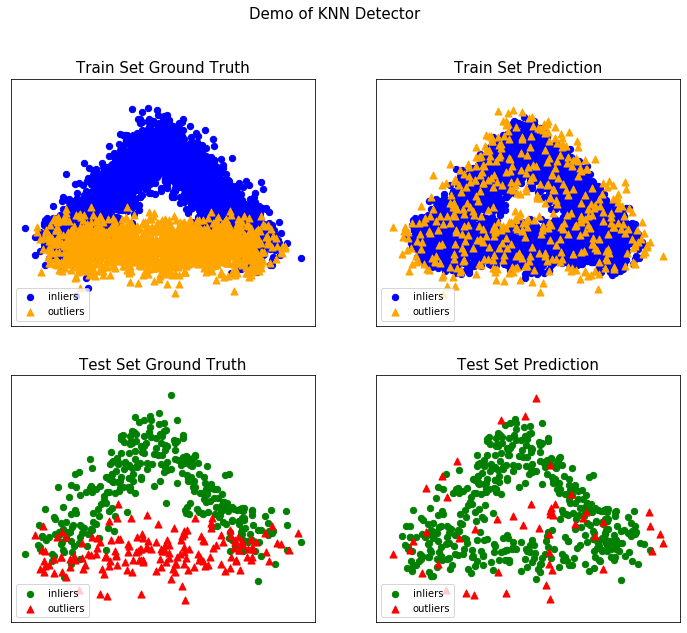

In [5]:
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
from pyod.utils.example import visualize
clf = KNN()

pca = PCA(n_components=3)
analyse_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=3)
analyse_test_set_feature = pca_test.fit_transform(test_set_feature)

# clf.fit(train_set_feature)
clf.fit(analyse_train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

# y_test_pred = clf.predict(test_set_feature)
# y_test_score = clf.decision_function(test_set_feature)
y_test_pred = clf.predict(analyse_test_set_feature)
y_test_score = clf.decision_function(analyse_test_set_feature)

print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'KNN'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

由于KNN是一个非监督的学习方法，可以看出，在这种类别比较少，且每个类别中的样本数比较平均，且维度特征比较高的情况下，KNN的效果不好。

# 使用IForest进行异常点分析

## 计算ROC-AUC分数并可视化 

Train AUC:0.5083084081090063, precision:0.3351206434316354
Test AUC:0.514661585919071, precision:0.3333333333333333


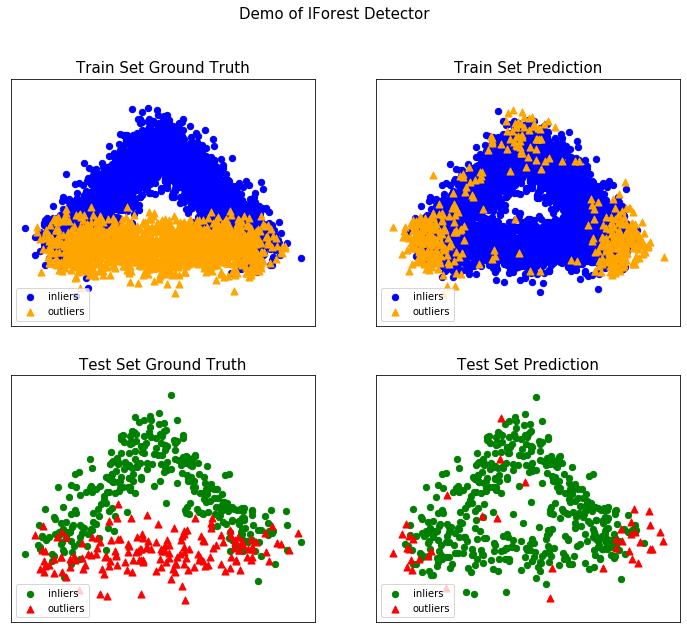

In [6]:
from pyod.models.iforest import IForest

clf = IForest()
# pca = PCA(n_components=1)
# analyse_train_set_feature = pca.fit_transform(train_set_feature)
# pca_test = PCA(n_components=1)
# analyse_test_set_feature = pca_test.fit_transform(test_set_feature)
analyse_train_set_feature = train_set_feature
analyse_test_set_feature = test_set_feature

# clf.fit(train_set_feature)
clf.fit(analyse_train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

# y_test_pred = clf.predict(test_set_feature)
# y_test_score = clf.decision_function(test_set_feature)
y_test_pred = clf.predict(analyse_test_set_feature)
y_test_score = clf.decision_function(analyse_test_set_feature)

print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'IForest'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

在使用IForest算法中，可以看出，IForest把各个类之间的边界点识别成了异常点，但是对于异常点类内部的点，IForest没有识别出来。

# 使用LOF进行异常点分析 

## 计算ROC-AUC分数并可视化  

Train AUC:0.5311192476677589, precision:0.3381858902575588
Test AUC:0.48469772350369367, precision:0.2828282828282828


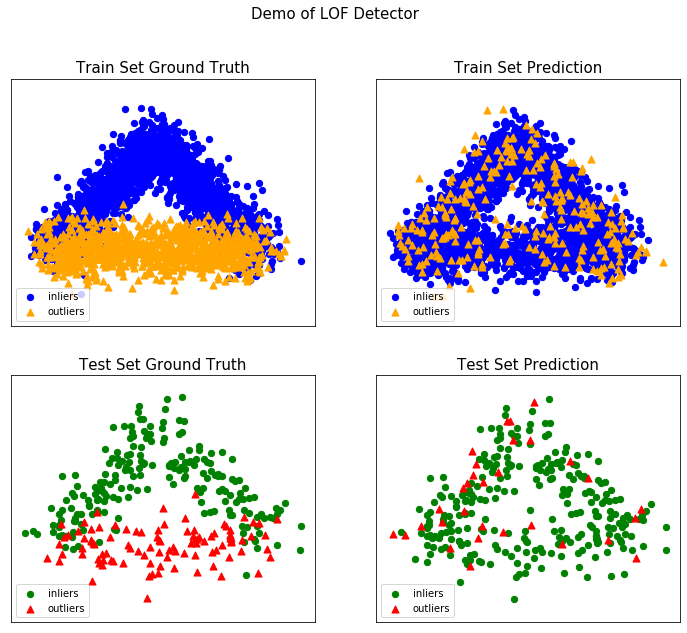

In [8]:
from pyod.models.lof import LOF

clf = LOF()
# pca = PCA(n_components=2)
# analyse_train_set_feature = pca.fit_transform(train_set_feature)
# pca_test = PCA(n_components=2)
# analyse_test_set_feature = pca_test.fit_transform(test_set_feature)
analyse_train_set_feature = train_set_feature
analyse_test_set_feature = test_set_feature

# clf.fit(train_set_feature)
clf.fit(analyse_train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

# y_test_pred = clf.predict(test_set_feature)
# y_test_score = clf.decision_function(test_set_feature)
y_test_pred = clf.predict(analyse_test_set_feature)
y_test_score = clf.decision_function(analyse_test_set_feature)
print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'LOF'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

使用IOF算法识别的结果，AUC在0.4-0.5之间，且从降维后的特征图来看，效果并不好，不能很好的把异常点分开。

# 使用OCSVM进行异常点分析 

## 计算ROC-AUC分数并可视化  

Train AUC:0.5178804632865786, precision:0.3303471444568869
Test AUC:0.5454545454545455, precision:0.37373737373737376


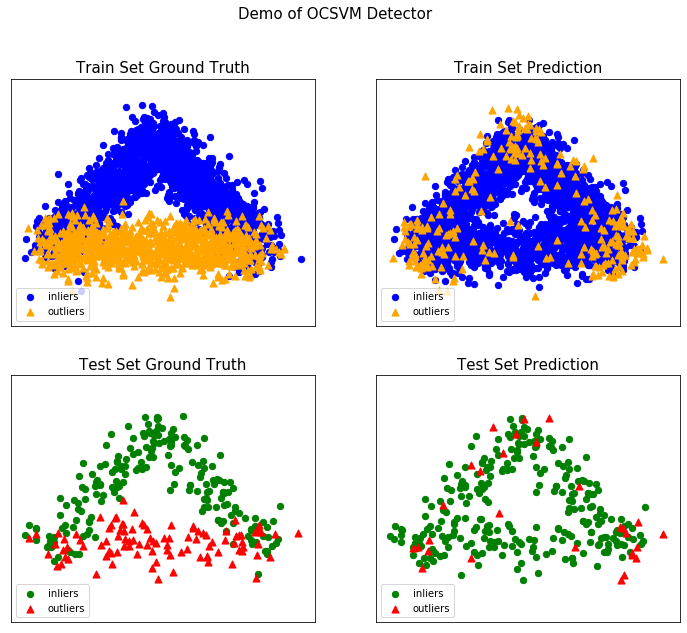

In [10]:
from pyod.models.ocsvm import OCSVM

clf = OCSVM()
# pca = PCA(n_components=2)
# analyse_train_set_feature = pca.fit_transform(train_set_feature)
# pca_test = PCA(n_components=2)
# analyse_test_set_feature = pca_test.fit_transform(test_set_feature)
analyse_train_set_feature = train_set_feature
analyse_test_set_feature = test_set_feature

# clf.fit(train_set_feature)
clf.fit(analyse_train_set_feature)
y_train_pred = clf.labels_
y_train_score = clf.decision_scores_

# y_test_pred = clf.predict(test_set_feature)
# y_test_score = clf.decision_function(test_set_feature)
y_test_pred = clf.predict(analyse_test_set_feature)
y_test_score = clf.decision_function(analyse_test_set_feature)

print('Train AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_train_label, y_train_score),
    prn=precision_n_scores(y_train_label, y_train_score)))

print('Test AUC:{roc}, precision:{prn}'.format(
    roc=roc_auc_score(y_test_label, y_test_score),
    prn=precision_n_scores(y_test_label, y_test_score)))
pca = PCA(n_components=2)
reduced_train_set_feature = pca.fit_transform(train_set_feature)
pca_test = PCA(n_components=2)
reduced_test_set_feature = pca_test.fit_transform(test_set_feature)
clf_name = 'OCSVM'
visualize(clf_name, reduced_train_set_feature, y_train_label, reduced_test_set_feature, y_test_label, y_train_pred, y_test_pred, show_figure=True, save_figure=False)

可以看出OCSVM和IForest比较类似，只能识别出各个类之间的边界的异常点，对于异常点内部的点，无法做出有效的识别。

# 全benchmark异常值分析 

最后，在所有wave_benchmark上，使用KNN、IForest、LOF和OCSVM异常值检测算法进行异常值检测，并把评估结果存储在wave_benchmark_result.csv中。

In [14]:
import os
import csv

root_path = 'D:/homework_for_data_mining/outlier detection/wave/benchmarks/'
csv_file_name = 'D:/homework_for_data_mining/outlier detection/wave/wave_benchmark_result.csv'
csv_file = open(csv_file_name, 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['file name', 'KNN-ROC', 'IForest-ROC', 'LOF-ROC', 'OCSVM-ROC'])
all_file = os.listdir(root_path)

for file_name in all_file:
    file_path = root_path + file_name
    meta_data = pd.read_csv(file_path, encoding='utf-8')
    ground_truth = meta_data[['ground.truth']]
    normal = ground_truth[ground_truth['ground.truth']=='nominal']
    anomaly = ground_truth[ground_truth['ground.truth']=='anomaly']
    normal_len = len(normal.index)
    anomaly_len = len(anomaly.index)
    total_len = normal_len + anomaly_len
    
    print(file_name)
    if anomaly_len >= normal_len or anomaly_len <=10:
        continue
    test_set_index, train_set_index = [], []
    normal_index = normal.index
    total_normal_index = np.arange(normal_len)
    
    normal_test_index = np.random.choice(total_normal_index, size=int(normal_len * 0.1), replace=False)
    normal_train_index = [_index for _index in total_normal_index if _index not in normal_test_index]
    test_set_index = normal_index[normal_test_index]
    train_set_index = normal_index[normal_train_index]
    anomaly_index = anomaly.index
    total_anomaly_index = np.arange(anomaly_len)
    anomaly_test_index = np.random.choice(total_anomaly_index, size=int(anomaly_len*0.1), replace=False)
    anomaly_train_index = [_index for _index in total_anomaly_index if _index not in anomaly_test_index]
    test_set_index =  test_set_index.append(anomaly_index[anomaly_test_index])
    train_set_index = train_set_index.append(anomaly_index[anomaly_train_index])

    train_set_feature = meta_data.loc[train_set_index, ['V','V.1','V.2','V.3','V.4','V.5','V.6','V.7','V.8','V.9','V.10','V.11','V.12','V.13','V.14','V.15','V.16','V.17','V.18','V.19','V.20']]
    train_set_feature = np.array(train_set_feature.values.tolist())
    test_set_feature = meta_data.loc[test_set_index, ['V','V.1','V.2','V.3','V.4','V.5','V.6','V.7','V.8','V.9','V.10','V.11','V.12','V.13','V.14','V.15','V.16','V.17','V.18','V.19','V.20']]
    test_set_feature = np.array(test_set_feature.values.tolist())
    train_set_groundtruth = meta_data.loc[train_set_index, 'ground.truth'].values.tolist()
    test_set_groundtruth = meta_data.loc[test_set_index, 'ground.truth'].values.tolist()
    y_train_label = np.array([0 if _label == 'nominal' else 1 for _label in train_set_groundtruth ])
    y_test_label = np.array([0 if _label == 'nominal' else 1 for _label in test_set_groundtruth ])
    
    # KNN method
    clf = KNN()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    knn_roc = roc_auc_score(y_test_label, y_test_score)
    
    # IForest method
    clf = IForest()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    iforest_roc = roc_auc_score(y_test_label, y_test_score)
    
    # LOF method
    clf = LOF()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    lof_roc = roc_auc_score(y_test_label, y_test_score)

    # OCSVM method
    clf = OCSVM()
    clf.fit(train_set_feature)
    y_train_pred = clf.labels_
    y_train_score = clf.decision_scores_
    y_test_pred = clf.predict(test_set_feature)
    y_test_score = clf.decision_function(test_set_feature)
    ocsvm_roc = roc_auc_score(y_test_label, y_test_score)
    
    
    csv_writer.writerow([file_name, knn_roc, iforest_roc, lof_roc, ocsvm_roc])

csv_file.close()
print('Results are saved in wave_benchmark_result.csv')


wave_benchmark_0001.csv
wave_benchmark_0002.csv
wave_benchmark_0003.csv
wave_benchmark_0004.csv
wave_benchmark_0005.csv
wave_benchmark_0006.csv
wave_benchmark_0007.csv
wave_benchmark_0008.csv
wave_benchmark_0009.csv
wave_benchmark_0010.csv
wave_benchmark_0011.csv
wave_benchmark_0012.csv
wave_benchmark_0013.csv
wave_benchmark_0014.csv
wave_benchmark_0015.csv
wave_benchmark_0016.csv
wave_benchmark_0017.csv
wave_benchmark_0018.csv
wave_benchmark_0019.csv
wave_benchmark_0020.csv
wave_benchmark_0021.csv
wave_benchmark_0022.csv
wave_benchmark_0023.csv
wave_benchmark_0024.csv
wave_benchmark_0025.csv
wave_benchmark_0026.csv
wave_benchmark_0027.csv
wave_benchmark_0028.csv
wave_benchmark_0029.csv
wave_benchmark_0030.csv
wave_benchmark_0031.csv
wave_benchmark_0032.csv
wave_benchmark_0033.csv
wave_benchmark_0034.csv
wave_benchmark_0035.csv
wave_benchmark_0036.csv
wave_benchmark_0037.csv
wave_benchmark_0038.csv
wave_benchmark_0039.csv
wave_benchmark_0040.csv
wave_benchmark_0041.csv
wave_benchmark_0